In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

pd.set_option("display.max_rows", None, "display.max_columns", None)
np.set_printoptions(suppress=True)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


# Loading data

In [2]:
train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
def datetime_divider(dataframe):
    if 'datetime' in dataframe.columns:
        dataframe['year'] = pd.to_datetime(dataframe['datetime']).dt.year
        dataframe['month'] = pd.to_datetime(dataframe['datetime']).dt.month
        dataframe['day'] = pd.to_datetime(dataframe['datetime']).dt.day
        dataframe['hour'] = pd.to_datetime(dataframe['datetime']).dt.hour
        dataframe.drop('datetime', axis=1, inplace=True, errors='ignore')
    else:
        # already divide
        return

In [5]:
datetime_divider(train)

# Correlation

<AxesSubplot:>

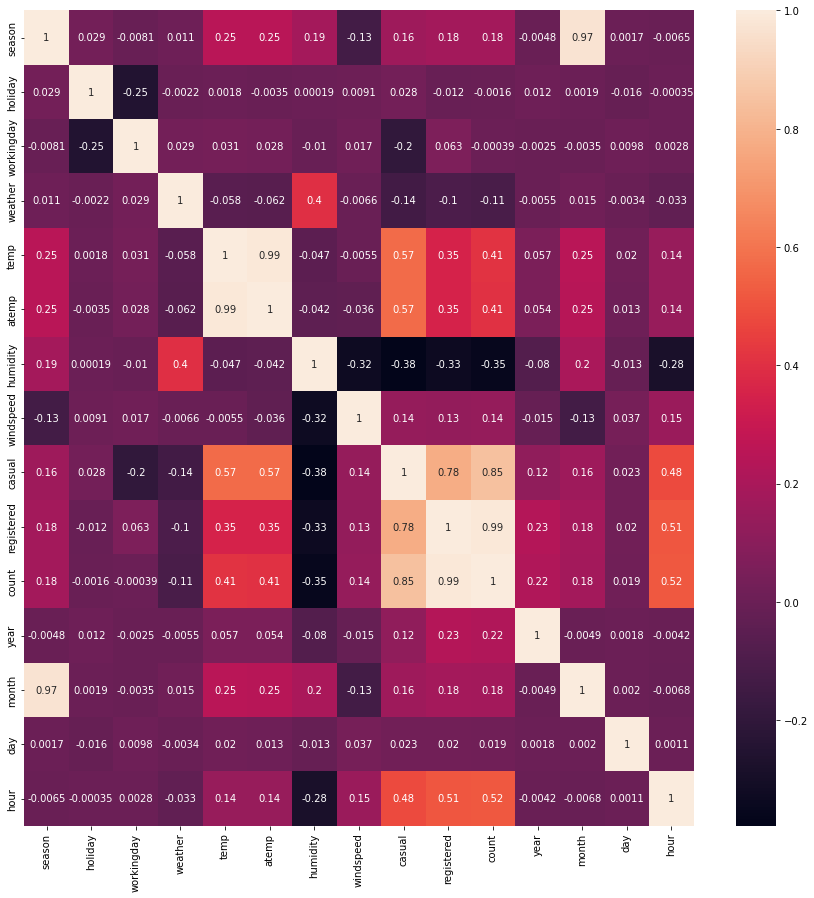

In [6]:
corr = train.corr(method='spearman')

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax)

# Temperature effect on `count`

Text(0.5, 1.0, 'Windspeed')

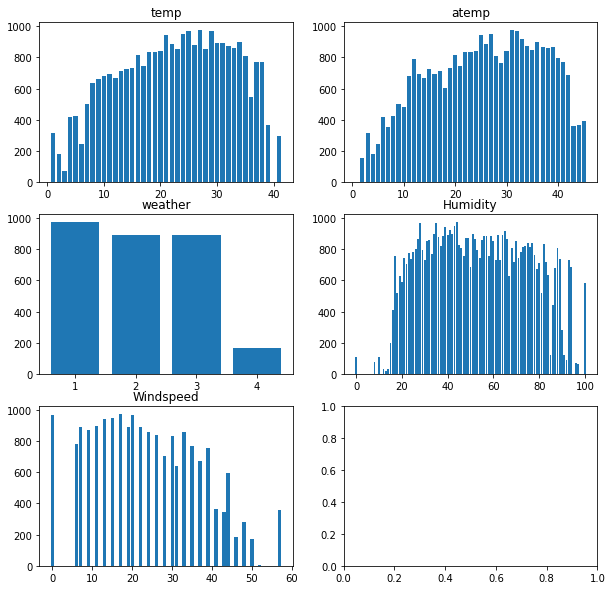

In [7]:
fig, axs = plt.subplots(3, 2,figsize=(10,10))
y = train['count']

x = train['temp'].round()
axs[0, 0].bar(x, y)
axs[0, 0].set_title('temp')

x = train['atemp'].round()
axs[0, 1].bar(x, y)
axs[0, 1].set_title('atemp')

x = train['weather']
axs[1, 0].bar(x, y)
axs[1, 0].set_title('weather')

x = train['humidity'].round()
axs[1, 1].bar(x, y)
axs[1, 1].set_title('Humidity')

x = train['windspeed'].round()
axs[2, 0].bar(x, y)
axs[2, 0].set_title('Windspeed')

# Time effect on `count`

Text(0.5, 1.0, 'hour')

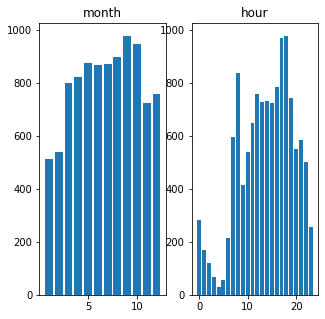

In [8]:
fig, axs = plt.subplots(1,2,figsize=(5,5))
y = train['count']

x = train['month']
axs[0].bar(x, y)
axs[0].set_title('month')

x = train['hour']
axs[1].bar(x, y)
axs[1].set_title('hour')

# Holiday decreases bicycle's want

In [9]:
train.groupby(['holiday',]).agg({'count':'sum'})

,count
holiday,
0,2027668
1,57808


# WorkingDay increases bicycle's want

In [10]:
train.groupby(['workingday',]).agg({'count':'sum'})

,count
workingday,
0,654872
1,1430604


# Dropping unnecessary columns
*`atemp` is calculated from `temp` `windspeed` and `weather`*

*`month` already contains information of `season`*

*`count` already contains information of `casual` and `registered`*

In [11]:
train.drop(['atemp','season','casual','registered'], axis=1, inplace=True)

# Dividing target variables

In [12]:
target = train[['count']].copy()
train.drop(['count'], axis=1, inplace=True)

# Dataframe to Numpy

In [13]:
X = train.to_numpy()
Y = target.to_numpy()

# Shape of X and Y

In [14]:
train.head()

,holiday,workingday,weather,temp,humidity,windspeed,year,month,day,hour
0,0,0,1,9.84,81,0.0,2011,1,1,0
1,0,0,1,9.02,80,0.0,2011,1,1,1
2,0,0,1,9.02,80,0.0,2011,1,1,2
3,0,0,1,9.84,75,0.0,2011,1,1,3
4,0,0,1,9.84,75,0.0,2011,1,1,4


In [15]:
X.shape

(10886, 10)

In [16]:
Y.shape

(10886, 1)

# Splitting data

In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=6)

# Model creation

In [18]:
RF = RandomForestRegressor(n_estimators = 100,random_state = 0, n_jobs=-1, verbose=1)
RF.fit(X_train, Y_train)

output = RF.predict(X_val)
mean_absolute_error(Y_val, output)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


27.733044077134984

In [19]:
output[:5]

array([144.69, 294.25, 221.71, 129.66, 585.77])

# 100% Data usage before prediction

In [20]:
RF.fit(X, Y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


RandomForestRegressor(n_jobs=-1, random_state=0, verbose=1)

# Submission

In [21]:
test_Id = test['datetime']
datetime_divider(test)
test.drop(['atemp','season'], axis=1, inplace=True)

prediction = RF.predict(test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [22]:
output = pd.DataFrame({'datetime': test_Id, 'count': prediction})
output.to_csv('submission.csv', index=False)